(2, 100)


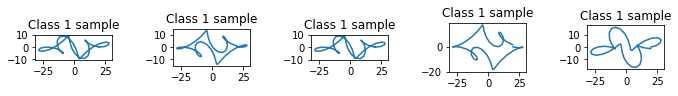

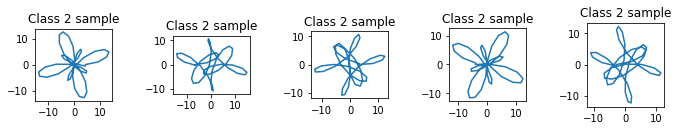

[[1. 0.]
 [1. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]
Labels shape (class 1 or 2): (10000, 1)
Attribute labels shape (continuous): (10000, 2)
[[1.]
 [1.]
 [1.]
 ...
 [2.]
 [2.]
 [2.]]
Shape vectors: (10000, 100)
(8000, 103) (2000, 103)


In [1]:
#
# implement a simple generative linear model with two "attributes", one that
# stretches the initial shape (average shape) vertically, and one that stretches it 
# horizontally. Of course, these attributes can be any linear transformation 
#
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
import json
from torch.utils.data import Dataset
import torch
import cv2
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

pi = 3.1415

arc = 350
radius = 10
number_of_samples = 3
vec_length = 100 # make sure it's even


def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

thetas = np.linspace(0, arc*pi/180, int(vec_length/2))
magni = radius * np.ones((1, int(vec_length/2))) * np.sin(np.linspace(0, 8*pi, int(vec_length/2)))

x, y = pol2cart(magni, thetas)
average = np.reshape(np.array([x, y]), (vec_length, 1))

attribute1 = np.zeros((vec_length, 1)) # horizontal stretch 
attribute1[:int(vec_length/2)] = np.reshape(np.cos(thetas), (-1, 1))
attribute2 = np.zeros((vec_length, 1)) # vertical stretch 
attribute2[int(vec_length/2):] = np.reshape(np.sin(thetas), (-1, 1))

attributes = np.squeeze(np.array((attribute1, attribute2)))

print(np.shape(attributes))
## generate training data 
#
# we'll say that the shapes with specific linear combinations of the attributes 
# are of one class, the rest of another 
# 
# in the example below, anything that is stretched vertically with a weight of 20 is 
# class 1, the rest are in class 2 
#

# generate 5 class 1 examples
number_of_samples = 5
attribute_sampler = np.random.randn(number_of_samples, 2) * 5 
attribute_sampler[:, 0] = 20 ## this attribute (horizontal stretch is exxagerated to make the sample class 1)
shapes = np.matmul(attribute_sampler, attributes).T + np.tile(average, (number_of_samples, ))
 
attribute_sampler
    
fig, ax = plt.subplots(1, number_of_samples, figsize=(10, 10))
fig.tight_layout(pad=3)
## plot them below to see what the individual components of the linear model do
for sample in range(number_of_samples):
# generate x samples given combined weight (same weight for all attributes)
    x = shapes[:int(vec_length/2), sample]
    y = shapes[int(vec_length/2):, sample]
    ax[sample].plot(x, y)
    ax[sample].set_aspect('equal')
    ax[sample].set_title("Class 1 sample")
plt.show()



# generate 5 class 2 examples
number_of_samples = 5
attribute_sampler = np.random.randn(number_of_samples, 2) * 5  # all attributes are normally distributed with 
                                                               # zero mean and s.t.d. 5 

shapes = np.matmul(attribute_sampler, attributes).T + np.tile(average, (number_of_samples, ))
 
attribute_sampler
    
fig, ax = plt.subplots(1, number_of_samples, figsize=(10, 10))
fig.tight_layout(pad=3)
## plot them below to see what the individual components of the linear model do
for sample in range(number_of_samples):
# generate x samples given combined weight (same weight for all attributes)
    x = shapes[:int(vec_length/2), sample]
    y = shapes[int(vec_length/2):, sample]
    ax[sample].plot(x, y)
    ax[sample].set_aspect('equal')
    ax[sample].set_title("Class 2 sample")
plt.show()



### you can use this as input to an MLP 

number_of_samples = 10000 # half of them will be class 1, half will be class 2
labels = np.ones((number_of_samples, 1))
labels[int(number_of_samples/2):, :] = 2

# generate 
attribute_sampler = np.random.randn(int(number_of_samples/2), 2) * 5 
attribute_sampler[:, 0] = 20 ## this attribute (horizontal stretch is exxagerated to make the sample class 1)
atttribute_sampler_1 = attribute_sampler
attribute_labels = np.array(attribute_sampler)
X1 = (np.matmul(attribute_sampler, attributes).T + np.tile(average, (int(number_of_samples/2), ))).T
attribute_sampler = np.random.randn(int(number_of_samples/2), 2) * 5 
X2 = (np.matmul(attribute_sampler, attributes).T + np.tile(average, (int(number_of_samples/2), ))).T
attribute_labels = np.concatenate((attribute_labels, attribute_sampler), axis=0)
attribute_labels[attribute_labels <= 0] = 0
attribute_labels[attribute_labels > 0] = 1
print(attribute_labels)
X = np.concatenate((X1, X2), axis=0)




print("Labels shape (class 1 or 2): " + str(np.shape(labels)))
print("Attribute labels shape (continuous): " + str(np.shape(attribute_labels)))
print(labels)
print("Shape vectors: " + str(np.shape(X)))

labels = labels - 1
synthetic_data = np.concatenate((X, labels, attribute_labels), axis=1)
#print(synthetic_data)
np.random.shuffle(synthetic_data)
#print(synthetic_data)
train_size = int(np.shape(synthetic_data)[0] * 0.8)
train_data = synthetic_data[:train_size, :]
test_data = synthetic_data[train_size:, :]
print(np.shape(train_data), np.shape(test_data))





In [2]:
attribute_sampler

array([[  1.25697463,   1.77066503],
       [ -7.58282987,   2.22348196],
       [ -1.19883275,  -3.66396661],
       ...,
       [  4.236561  ,  -4.32528463],
       [-10.64452746,   5.8460086 ],
       [  6.46165719,  -3.25865853]])

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class syntheticDataset(Dataset):
    def __init__(self, synthetic_data):
        
        labels = synthetic_data[:, -3]
        X = synthetic_data[:, :-3]
        self.data = X
        self.target = labels
        self.attrib1 = synthetic_data[:, -2]
        self.attrib2 = synthetic_data[:, -1]
    def __len__(self):
        return len(self.data)
  
    def __getitem__(self, idx):
        
        data = self.data[idx]
        label = self.target[idx]
        data = torch.from_numpy(data)
        attrib1 = self.attrib1[idx]
        attrib2 = self.attrib2[idx]
        sample = {"image": data, "target": label, "attrib1": attrib1, "attrib2": attrib2}
        return sample


In [4]:
training_set = syntheticDataset(train_data)


parameters_train = {
    "batch_size": 8,
    "shuffle": True,
}
parameters_test = {
    "batch_size": 1,
    "shuffle": False,
}
training_generator = torch.utils.data.DataLoader(training_set, **parameters_train)

totiter = len(training_generator)

In [5]:
class MLP(nn.Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(n_inputs, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 2)
        self.fcG = nn.Linear(2, 4)
        self.fcW = nn.Linear(4, 1)
      
 
    # forward propagate input
    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.sigmoid(self.fc3(X))
        pred = self.fcG(X)
        pred = self.fcW(pred)
        pred = F.sigmoid(pred)
        return X, pred

In [ ]:
model = MLP(vec_length)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.BCELoss(reduction='mean')

def projection_simplex_sort(v, z=1):

    n_features = v.size(1)
    u,_ = torch.sort(v, descending=True)
    cssv = torch.cumsum(u,1) - z
    ind = torch.arange(n_features).type_as(v) + 1
    cond = u - cssv / ind > 0
    #rho = ind[cond][-1]
    rho,ind_rho = (ind*cond).max(1)
    #theta = cssv[cond][-1] / float(rho)
    theta = torch.gather(cssv,1,ind_rho[:,None]) / rho[:,None]
    w = torch.clamp(v - theta, min=0)
    return w 

for epoch in range(150):
    running_loss = 0.0
    #model.train()
    for data in training_generator:
        #model.train(True)
        x_im_train = data["image"]
        x_im_train = x_im_train.to(device)
        
        y_train = data["target"]
        attr1_train = data["attrib1"]
        attr2_train = data["attrib2"]
        optimizer.zero_grad()

        attribs, output = model(x_im_train.float())
        #print(attribs, output)
        
        attrib_pred1 = attribs[:, 0].reshape(parameters_train["batch_size"], 1)
        attrib_pred2 = attribs[:, 1].reshape(parameters_train["batch_size"], 1)
        # this needs work 
        loss_y = criterion(output, y_train.reshape(parameters_train["batch_size"], 1).to(device).float())
        loss_a1 = criterion(attrib_pred1, attr1_train.reshape(parameters_train["batch_size"], 1).to(device).float())
        loss_a2 = criterion(attrib_pred2, attr2_train.reshape(parameters_train["batch_size"], 1).to(device).float())
        loss = loss_y + loss_a1 + loss_a2
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        model.fcG.weight.data = projection_simplex_sort(model.fcG.weight.data)
    epoch = epoch + 1
    print("Epoch: ", epoch, "; running-loss: ", running_loss)

/home/ahana/anaconda3/envs/dl_env/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch:  1 ; running-loss:  1447.829541862011
Epoch:  2 ; running-loss:  1071.6950438022614
Epoch:  3 ; running-loss:  956.4323378205299
Epoch:  4 ; running-loss:  897.8731756806374
Epoch:  5 ; running-loss:  861.6479474306107
Epoch:  6 ; running-loss:  837.3441134095192
Epoch:  7 ; running-loss:  820.2198839187622
Epoch:  8 ; running-loss:  806.8508701324463
Epoch:  9 ; running-loss:  796.0103268027306
Epoch:  10 ; running-loss:  786.3726226091385
Epoch:  11 ; running-loss:  778.6508236527443
Epoch:  12 ; running-loss:  771.6047885417938
Epoch:  13 ; running-loss:  765.7569727301598
Epoch:  14 ; running-loss:  760.1333807110786
Epoch:  15 ; running-loss:  754.9764385819435
Epoch:  16 ; running-loss:  750.4466633796692
Epoch:  17 ; running-loss:  746.0358665585518
Epoch:  18 ; running-loss:  741.9031924009323
Epoch:  19 ; running-loss:  738.190721809864
Epoch:  20 ; running-loss:  734.7542709112167
Epoch:  21 ; running-loss:  731.1449325084686
Epoch:  22 ; running-loss:  728.04615336656

In [8]:
test_set = syntheticDataset(test_data)
test_generator = torch.utils.data.DataLoader(test_set, **parameters_test)
count = 0
correct = 0
attr1_correct = 0
attr2_correct = 0
for data in test_generator:
    x_test = data["image"].to(device)
    
    attribs, pred = model(x_test.float())
    pred = pred.detach().cpu().numpy()
    attribs = attribs.detach().cpu().numpy()
    y_test = data["target"]
    y_attr1 = data["attrib1"]
    y_attr2 = data["attrib2"]
    pred[pred >= 0.5] = 1
    pred[pred < 1] = 0
    if pred[0][0] == y_test[0]:
        correct += 1

    attribs[attribs >= 0.5] = 1
    attribs[attribs < 1] = 0
    if attribs[0][0] == y_attr1[0]:
        attr1_correct += 1
    if attribs[0][1] == y_attr2[0]:
        attr2_correct += 1
    count += 1
    
print("% correct=", (correct / count) * 100)
print("% attrib1 correct=", (attr1_correct / count) * 100)
print("% attrib2 correct=", (attr2_correct / count) * 100)


% correct= 100.0
% attrib1 correct= 100.0
% attrib2 correct= 99.7
